In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from itertools import chain

vims_wave = np.loadtxt('vims_wave.txt')
new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
for number in new_array:
    new_string = 'df'+number+' = '+'pd.read_pickle("e_data/data'+number+'.pkl")'
    exec(new_string)

#Functions for later

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [3]:
spec_list = [] #UNFILTERED - shorthand name means that the data has not been fit or filtered
for number in new_array:
    my_string = 'spec'+number+" = df"+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    new_spec = locals()[spec]
    spec_list.append(new_spec)

time_list = []
for number in new_array:
    my_string = 'ettime'+number+" = df"+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list.append(locals()[time])

### Fitting All Spectra

In [4]:
#Define all fit spectra under one single list (specific year groups will be added later)
spectrum_list = [] #total SPECTRUM list
mean_list = [] #List for shifts to be plotted later
ettime_list = []
for (df,tf) in zip(spec_list,time_list):
    for (spectrum,time) in zip(df,tf):
        fit_thing = single_fit(spectrum)
        std = np.std(fit_thing[150:200]) # Variance of the I/F values
        ind = np.where((fit_thing>=0.17)|(fit_thing<=-.03))
        
        if len(ind) == 0 or std<.005:
            spectrum_list.append(fit_thing)
            my_fit,_ = curve_fit(gaussian,vims_wave[window],fit_thing[window],p0=[.05,2,.05])
            mean_list.append(my_fit[1])
            ettime_list.append(time)

# Convert all lists objects within total_list to numpy arrays
spectrum_array = np.asarray(spectrum_list)
time_array = np.asarray(ettime_list)
print(np.shape(spectrum_array)) 
print(np.shape(time_array)) 

(11779, 256)
(11779,)


### Sort the two lists together!

params = spectrum_array.argsort()
spectrum_array = spectrum_array[params]
time_array = time_array[params]

In [4]:
time_array -= np.min(time_array) # Subtracting youngest time from all values
time_array /= np.pi * 10**7 # Converts to years

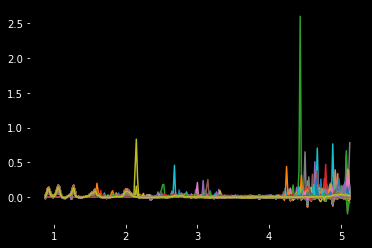

In [5]:
%matplotlib inline
fig,ax = plt.subplots(1,facecolor='black')
for spectrum in spectrum_list:
    plt.plot(vims_wave,spectrum)

for ax in fig.get_axes():
    ax.tick_params(axis='x',colors='white')
    ax.tick_params(axis='y',colors='white')

ax.set_facecolor('k')
plt.show()